This script is for calculating the specific surface area ($S_{BET}$) of a solid sample, including error from Inverse Gas Chromatography measurements, specifically those done on the SEA (Surface energy analyser). Measured parameters are imported from a csv file and the specific surface area of the sample is printed at the end of the document along with visualisations of the adsorption isotherm and BET plot.

In [6]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
from scipy import stats, constants
import matplotlib.pyplot as plt
%matplotlib inline

# Organising data

In [7]:
# Reads csv input file and skips rows to where data start
df = pd.read_csv(raw_input('Copy path to input file here \nmake sure to insert extra "\\" and remove "" \n'), skiprows = 17)

Copy path to input file here 
make sure to insert extra "\" and remove "" 
satest2.csv


In [8]:
# Removing of solvents that arent used in calculation
df= df[(df.Solvent != 'n/a') & (df.Solvent != 'Methane')]

In [9]:
# Renaming columns with funny character
df.rename(columns ={'Peak Area [\xb5V\x95min]': 'peak_area', 'Peak Max (Signal) [\xb5V]': 'peak_max_signal'},inplace=True)

# Removing unwanted rows
df = df[df.peak_area != 0]

#  James-Martin pressure correction, j

$$j=\frac{3}{2}\frac{(\frac{p_{in}}{p_{out}})^{2}-1}{(\frac{p_{in}}{p_{out}})^{3}-1}$$

In [10]:
# Atmospheric pressure in torr
p_out = 760

# input pressure is pressure drop + atomospheric pressure
p_in = df['Column Pressure Drop [Torr]'] + p_out

j = (1.5*(((p_in/p_out)**2 -1)/((p_in/p_out)**3 -1)))

# Net Retention Volume, Vn ($\frac{mL}{g}$)

$$V_{N}=\frac{j}{m}F(t_{r}-t_{0})(\frac{T}{273.15})$$

In [11]:
# Creating input for sample mass and change its units
m = float(raw_input('What is the sample mass in mg? \n'))
m = m / 1000 # mg to g

vn = (j * df['Exit Flow Rate [sccm]'] * df['Net Ret Time (Max) [min]'] * df['Column Temperature [Kelvin]'] ) / (m * 273.15)

What is the sample mass in mg? 
7


# Partial pressure, p (Pa)

$$p=\frac{n_{i}RH_{peak}273.15}{FA_{peak}}$$

In [12]:
A_peak = df['peak_area']
n_i = df['Amount  [mMol]']
H_peak = df['peak_max_signal']
F = df['Exit Flow Rate [sccm]']

In [13]:
# Converting units to SI

vn_SI = vn * 0.001 # converts mg/L to m^3/kg
A_peak = A_peak * 6E-5 #converts uV.min to V.sec
n_i = n_i / 1000 # converts mMol to Mol
H_peak = H_peak * 1E-6 # converts uV to V
F = F * 1.6667E-8 #from sscm to m^3/s

In [14]:
# Gas constant
R = constants.R

In [15]:
p = (n_i * R * 273.15 * H_peak) / (F * A_peak) # Pa

#  Amount of probe adsorbed on sample surface, n, ($\frac{mMol}{g}$)

$$n=\frac{1}{RT}\intop_{0}^{p}V_{n}dp$$

In [16]:
# Reindexing series to start at zero
p_reindex = p.reset_index(drop=True)
vn_SI_reindex = vn_SI.reset_index(drop=True)

In [17]:
# T value used in n calc
T_av = df['Column Temperature [Kelvin]'].mean()

In [18]:
# set n as empty array in shape of as other values 
n = np.empty_like(p_reindex)

In [19]:
# Cumulative integration  of vn with respect to partial pressure p
n[0] = (p_reindex[0] * vn_SI_reindex[0]) / (R * T_av)
for i in range(1, len(p_reindex)):
    n[i] = (p_reindex[i] - p_reindex[i - 1]) * (vn_SI_reindex[i] / (R * T_av)) + n[i - 1]

In [20]:
# set n as series with same index as p_reindex and vn_SI_reindex
n = Series(n)

# Saturation vapour pressure calculation, $p_{sat}$ (Pa)

$$\log_{10}p_{sat}=A-\frac{B}{C+T}$$
$$p_{sat}=10^{(A-\frac{B}{C+T})}$$

In [21]:
# Antoine coefficients for octane (probe used for surface area calculations from yaws handbook (knovel.com))

In [22]:
# Coefficents A,B,C are for T = 20C
A = 7.14462
B = 1498.96
C = 225.874

p_sat = 10 ** (A- (B /(20+C))) # mmHg T= 20C
p_sat = p_sat * 133.322 # mmHg to Pa

# Relative pressure, $p_{rel}$

$$p_{rel}=\frac{p}{p_{sat}}$$

In [23]:
p_rel = p_reindex / p_sat

# Adsorption Isotherm Plot

(0, 0.092176011827600698)

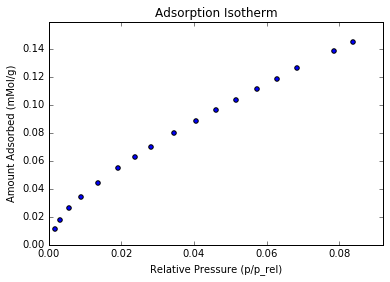

In [24]:
plt.scatter(p_rel, n)
plt.title('Adsorption Isotherm')
plt.xlabel('Relative Pressure (p/p_rel)')
plt.ylabel('Amount Adsorbed (mMol/g)')
x_max = max(p_rel) + (0.1 * max(p_rel))
y_max = max(n) + (0.1 * max(n))
plt.ylim(0,y_max)
plt.xlim(0,x_max)

#  BET  equation plot and calculation

$$\frac{p}{n(p-p_{sat})}=\frac{C-1}{n_{m}C}\frac{p}{p_{sat}}+\frac{1}{n_{m}C}$$

In [25]:
# setting Y axis for BET plot
y_BET = p_reindex / (n * (p_sat - p_reindex))

In [26]:
# set up BET dataframe
BET_df = pd.concat([p_rel, y_BET], axis = 1)
BET_df.columns = ['p_rel', 'y_BET']

In [27]:
# BET equation is only valid between p_rel values of 0.05 to 0.35
BET_df = BET_df[(BET_df.p_rel >= 0.05) & (BET_df.p_rel <= 0.35)]

In [28]:
BET_df

,p_rel,y_BET
11,0.051582,0.525038
12,0.057278,0.546314
13,0.062783,0.565115
14,0.068421,0.583640
15,0.078564,0.616404
16,0.083796,0.632057


In [29]:
# Function does linear regression and if threshold r_sq values isnt reached it removes the first row of dataframe
# First row is removed because generally BET data is better at higher p_rel
def regress(df):
    # Linear regression of BET plot within allowed p_rel range
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['p_rel'],df['y_BET'])
    
    r_sq = r_value ** 2
    
    if r_sq < 0.995:
        
        return regress(df.iloc[1:]) # re-runs function with first row removed, removes first row until threshold r_sq reached
    else:
        # Calculations used for finding error in intercept from 'https://en.wikipedia.org/wiki/Regression_analysis'
        sse = ((df['y_BET'] - ((slope * df['p_rel']) + intercept)) ** 2).sum()
        n = len(df['p_rel'])
        var = np.sqrt((sse / (n - 2)))
        x_mean = df['p_rel'].mean()
        sx2 = ((df['p_rel'] - x_mean) **2).sum()
        intercept_err = var * np.sqrt((1/n) + (x_mean ** 2) / sx2)
        
        return slope,intercept,r_value,p_value,std_err,r_sq, intercept_err

In [30]:
slope,intercept,r_value,p_value, std_err, r_sq,intercept_err = regress(BET_df)

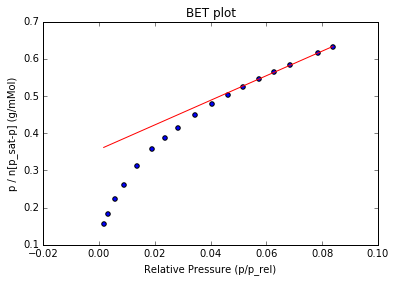

In [31]:
# BET plot
plt.scatter(p_rel,y_BET)
plt.plot(p_rel, (p_rel * slope) + intercept, c='r')
plt.title('BET plot')
plt.xlabel('Relative Pressure (p/p_rel)')
plt.ylabel('p / n[p_sat-p] (g/mMol)')


$$n_{m}=\frac{1}{slope+intercept}$$

In [32]:
# The monolayer capacity, n_m is found from slope and intercept of fitted line from BET plot

n_m = 1 / (slope + intercept) # mMol/g
err_slope_intercept = np.sqrt((std_err) ** 2 + (intercept_err) ** 2) # error in slope+intercept
n_m_err = n_m * (err_slope_intercept / (slope + intercept)) # error in n_m
n_m = n_m / 1000 # change units from mMol/g to Mol/g
n_m_err = n_m_err / 1000 # change units from mMol/g to Mol/g

#  Specific Surface Area, $\frac{m^{2}}{g}$

$$S_{BET}=n_{m}N_{a}a$$

In [33]:
a = 6.3E-19 # m^2 This is the cross-sectional surface area of a Octane molecule
Na = constants.Avogadro

In [34]:
ssa = n_m * Na * a
ssa_err = ssa * (n_m_err / n_m)

In [35]:
print 'The SSA is %.2f with error %.2f' % (ssa,ssa_err)

The SSA is 103.58 with error 1.47
